In [332]:
#Task 1: Data Preprocessing

import pandas as pd

# Try different encodings until you find the one that works
try:
    data = pd.read_csv('data.csv', encoding='utf-8')
except UnicodeDecodeError:
    try:
        data = pd.read_csv('data.csv', encoding='latin-1')
    except UnicodeDecodeError:
        data = pd.read_csv('data.csv', encoding='iso-8859-1')

print(data.head())  # This will display the first few rows of your data

  InvoiceNo StockCode                          Description  Quantity  \
0    536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER         6   
1    536365     71053                  WHITE METAL LANTERN         6   
2    536365    84406B       CREAM CUPID HEARTS COAT HANGER         8   
3    536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE         6   
4    536365    84029E       RED WOOLLY HOTTIE WHITE HEART.         6   

      InvoiceDate  UnitPrice  CustomerID         Country  
0  12/1/2010 8:26       2.55     17850.0  United Kingdom  
1  12/1/2010 8:26       3.39     17850.0  United Kingdom  
2  12/1/2010 8:26       2.75     17850.0  United Kingdom  
3  12/1/2010 8:26       3.39     17850.0  United Kingdom  
4  12/1/2010 8:26       3.39     17850.0  United Kingdom  


In [334]:
missing_values = data.isnull().sum()
print("Missing Values")
print(missing_values)

Missing Values
InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64


In [336]:
total_rows = data.shape[0]
print(f"Total number of rows: {total_rows}")

Total number of rows: 541909


In [338]:
print("Data Types:")
print(data.dtypes)

Data Types:
InvoiceNo       object
StockCode       object
Description     object
Quantity         int64
InvoiceDate     object
UnitPrice      float64
CustomerID     float64
Country         object
dtype: object


In [340]:
data['CustomerID'].fillna(data['CustomerID'].mean(), inplace=True)

/var/folders/dk/ty44k4f97tl78kr03dymv92c0000gn/T/ipykernel_46709/3176185670.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data['CustomerID'].fillna(data['CustomerID'].mean(), inplace=True)


In [342]:
missing_values = data.isnull().sum()
print("Missing Values:")
print(missing_values)

Missing Values:
InvoiceNo         0
StockCode         0
Description    1454
Quantity          0
InvoiceDate       0
UnitPrice         0
CustomerID        0
Country           0
dtype: int64


In [326]:
data['Description'] = data['Description'].fillna('Unknown')

In [26]:
missing_values = data.isnull().sum()
print("Missing Values")
print(missing_values)

Missing Values
InvoiceNo      0
StockCode      0
Description    0
Quantity       0
InvoiceDate    0
UnitPrice      0
CustomerID     0
Country        0
dtype: int64


In [34]:
# Task 2: RFM Calculation

import pandas as pd
data['InvoiceDate']=pd.to_datetime(data['InvoiceDate'])
current_date = data['InvoiceDate'].max()
recency = current_date - data.groupby('CustomerID')['InvoiceDate'].max()
recency = recency.dt.days
frequency = data.groupby('CustomerID')['InvoiceDate'].nunique()
monetary = data.groupby('CustomerID').agg({'Quantity': 'sum', 'UnitPrice': 'sum'})
monetary['Monetary'] = monetary['Quantity'] * monetary['UnitPrice'] 
rfm_data = pd.DataFrame({
    'Recency': recency,
    'Frequency': frequency,
    'Monetary' : monetary['Monetary']
})
print(rfm_data.head())

            Recency  Frequency    Monetary
CustomerID                                
12346.0         325          2        0.00
12347.0           1          7  1182814.18
12348.0          74          4   418360.11
12349.0          18          1   381818.10
12350.0         309          1    12864.10


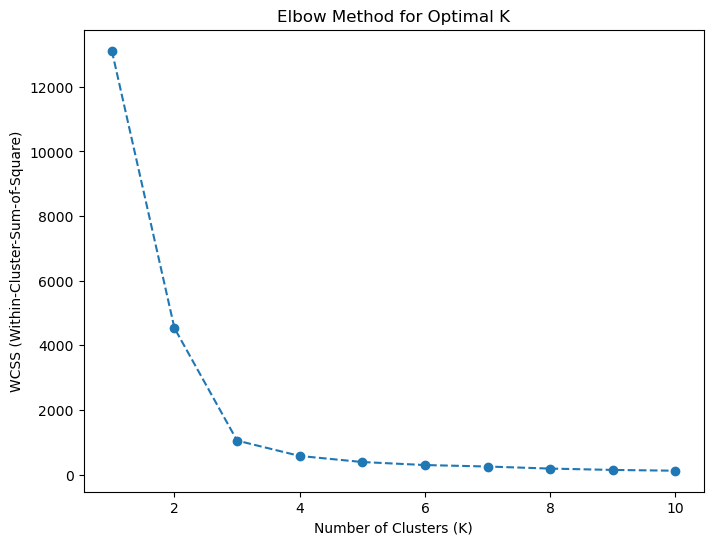

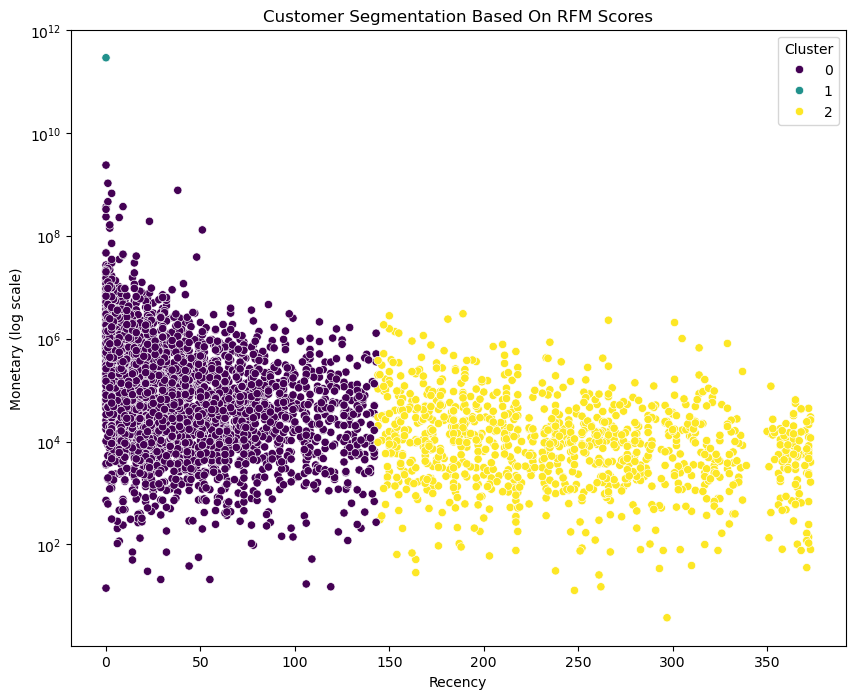

In [42]:
# Task 3: RFM Segmentation, Customer Segmentation and Visualization

from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns

rfm_for_clustering = rfm_data[['Recency', 'Frequency', 'Monetary']]
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(rfm_for_clustering)

wcss = []

for i in range (1,11):
    kmeans = KMeans(n_clusters=i, init='k-means++', random_state=42)
    kmeans.fit(rfm_scaled)
    wcss.append(kmeans.inertia_)

plt.figure(figsize=(8, 6))
plt.plot(range(1,11), wcss, marker='o', linestyle='--')
plt.title('Elbow Method for Optimal K')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('WCSS (Within-Cluster-Sum-of-Square)')
plt.show()

optimal_k = 3

kmeans = KMeans(n_clusters=optimal_k, init='k-means++', random_state=42)
rfm_data['Cluster'] = kmeans.fit_predict(rfm_scaled)

plt.figure(figsize=(10, 8))
sns.scatterplot(x='Recency', y='Monetary', hue='Cluster', data=rfm_data, palette='viridis', legend='full')

plt.yscale('log')

plt.title('Customer Segmentation Based On RFM Scores')
plt.xlabel('Recency')
plt.ylabel('Monetary (log scale)')
plt.show()

                

In [48]:
#Task 4: Segment Profiling

segment_profiles = rfm_data.groupby('Cluster').agg({
    'Recency': 'mean',
    'Frequency': 'mean',
    'Monetary' : 'mean',
}).reset_index()

segment_profiles['Number of Customers'] = rfm_data['Cluster'].value_counts().sort_index().values

segment_profiles = segment_profiles.rename(columns={
    'Recency': 'Average Recency',
    'Frequency': 'Average Frequency',
    'Monetary' : 'Average Monetary',
})
print(segment_profiles)


   Cluster  Average Recency  Average Frequency  Average Monetary  \
0        0        39.544073           6.078419      3.127292e+06   
1        1         0.000000        3161.000000      2.940878e+11   
2        2       247.650647           1.881701      5.499812e+04   

   Number of Customers  
0                 3290  
1                    1  
2                 1082  


In [ ]:
#Task 5: Marketing Recommendations

In [322]:
#1.Data Overview:
#(a)
print(f"Dataset Size: {data.shape}")

Dataset Size: (541909, 15)


In [324]:
#(b)
print("\nColumn Descriptions:")
print(data.info())

print("\nSummary Statistics for Numerical Columns:")
print(data.describe())


Column Descriptions:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 15 columns):
 #   Column               Non-Null Count   Dtype          
---  ------               --------------   -----          
 0   InvoiceNo            541909 non-null  object         
 1   StockCode            541909 non-null  object         
 2   Description          540455 non-null  object         
 3   Quantity             541909 non-null  int64          
 4   InvoiceDate          541909 non-null  datetime64[ns] 
 5   UnitPrice            541909 non-null  float64        
 6   CustomerID           541909 non-null  float64        
 7   Country              541909 non-null  object         
 8   TotalAmount          541909 non-null  float64        
 9   Year                 541909 non-null  int32          
 10  Month                541909 non-null  int32          
 11  DayOfWeek            541909 non-null  object         
 12  HoursOfDay           541909 non-null

In [310]:
#(c)
print("\nTime Period Covered:")
print("Minimum Invoice Date:", data['InvoiceDate'].min())
print("Maximum Invoice Date:", data['InvoiceDate'].max())


Time Period Covered:
Minimum Invoice Date: 2010-12-01 08:26:00
Maximum Invoice Date: 2011-12-09 12:50:00


In [308]:
#2. Customer Analysis:
#(a)

unique_customers = data['CustomerID'].nunique()
print("Number of Unique Customers:", unique_customers)


Number of Unique Customers: 4373


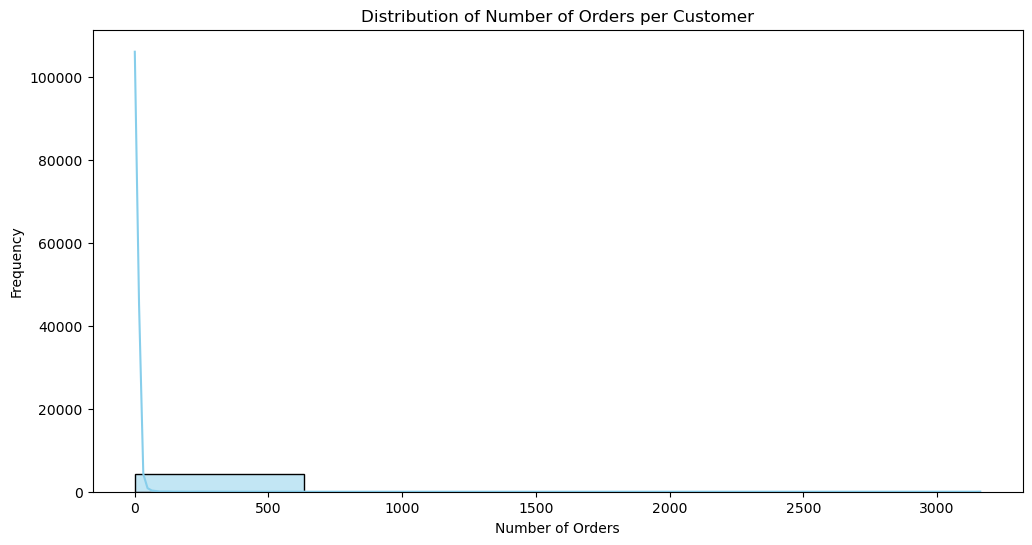

In [306]:
#(b)
import matplotlib.pyplot as plt
import seaborn as sns

orders_per_customer = data.groupby('CustomerID')['InvoiceDate'].nunique()

plt.figure(figsize=(12, 6))
sns.histplot(orders_per_customer, bins=5, kde=True, color='skyblue')
plt.title('Distribution of Number of Orders per Customer')
plt.xlabel('Number of Orders')
plt.ylabel('Frequency')
plt.show()



In [304]:
#(c)
top_customers_by_order_count = data.groupby('CustomerID')['InvoiceNo'].nunique().sort_values(ascending=False)

top_5_customers = top_customers_by_order_count.head(5)

print("Top 5 Customer and Order Count:")
print(top_5_customers)
      

Top 5 Customer and Order Count:
CustomerID
15287.69057    3710
14911.00000     248
12748.00000     224
17841.00000     169
14606.00000     128
Name: InvoiceNo, dtype: int64


In [298]:
#3. Product Analysis:
#(a)
top_products_by_frequency = data['StockCode'].value_counts().head(10)

print("Top 10 Most Frequently Purchased Products:")
print(top_products_by_frequency)

Top 10 Most Frequently Purchased Products:
StockCode
85123A    2313
22423     2203
85099B    2159
47566     1727
20725     1639
84879     1502
22720     1477
22197     1476
21212     1385
20727     1350
Name: count, dtype: int64


In [294]:
#(b)
average_price = data['UnitPrice'].mean()
print("Average Price of Products:", average_price)

Average Price of Products: 4.611113626088513


In [296]:
#(b)
data['Revenue']=data['Quantity'] * data['UnitPrice']
top_revenue_category = data.groupby('Description')['Revenue'].sum().idxmax()
print("Product Category Generating the Highest Revenue:", top_revenue_category)

Product Category Generating the Highest Revenue: DOTCOM POSTAGE


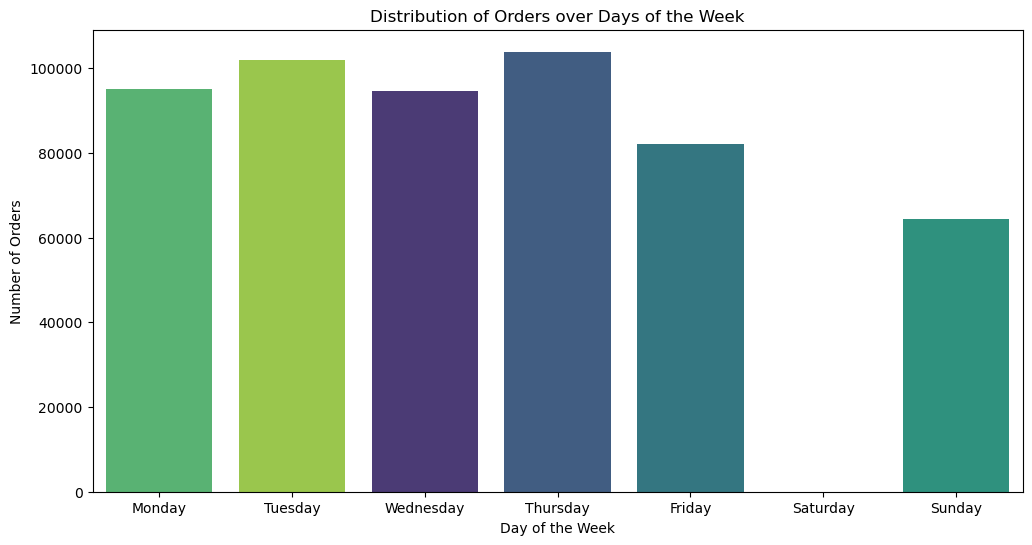

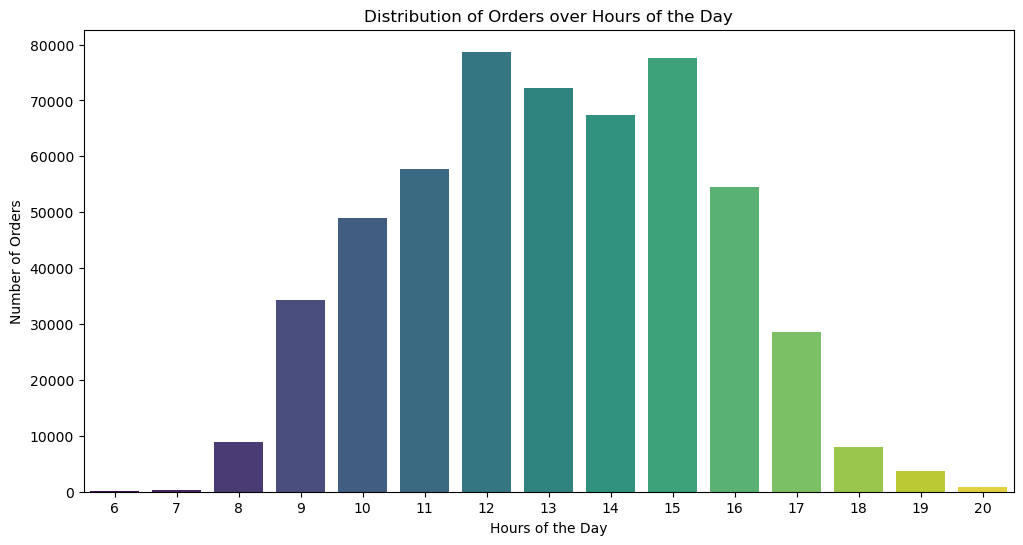

In [292]:
#4. Time Analysis
#(a)
import matplotlib.pyplot as plt
import seaborn as sns

data['InvoiceDate'] = pd.to_datetime(data['InvoiceDate'])

data['DayOfWeek'] = data['InvoiceDate'].dt.day_name()
data['HoursOfDay'] = data['InvoiceDate'].dt.hour

plt.figure(figsize=(12, 6))
sns.countplot(x='DayOfWeek', data=data, hue='DayOfWeek', legend=False, palette='viridis', order=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])
plt.title('Distribution of Orders over Days of the Week')
plt.xlabel('Day of the Week')
plt.ylabel('Number of Orders')
plt.show()

plt.figure(figsize=(12, 6))
sns.countplot(x='HoursOfDay', data=data, hue='HoursOfDay', legend=False, palette='viridis')
plt.title('Distribution of Orders over Hours of the Day')
plt.xlabel('Hours of the Day')
plt.ylabel('Number of Orders')
plt.show()



In [290]:
#(b)
data['InvoiceDate'] = pd.to_datetime(data['InvoiceDate'])


data['OrderProcessingTime'] = data.groupby('InvoiceNo')['InvoiceDate'].transform(lambda x: x.max() -  x.min())
average_processing_time = data['OrderProcessingTime'].mean()
print("Average Order Processing Time:", average_processing_time)



Average Order Processing Time: 0 days 00:00:00.370578824


In [276]:
#(c)
data['InvoiceDate'] = pd.to_datetime(data['InvoiceDate'])

data['Year'] = data['InvoiceDate'].dt.year
data['Month'] = data['InvoiceDate'].dt.month
data['DayOfWeek'] = data['InvoiceDate'].dt.day_name()



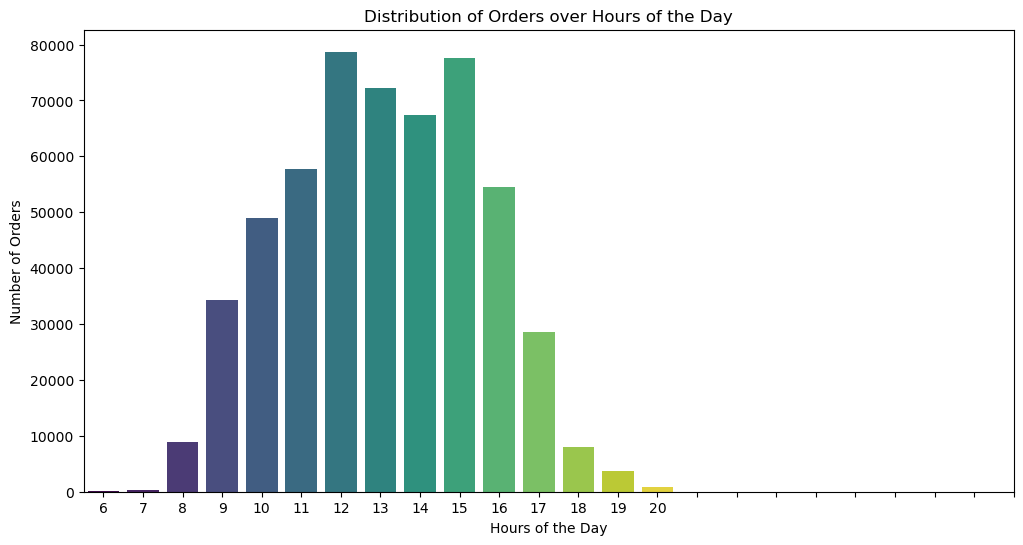

In [288]:
#(c)
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming 'data' is your DataFrame and has been defined previously

# Step 1: Convert 'InvoiceDate' to datetime if it's not already
data['InvoiceDate'] = pd.to_datetime(data['InvoiceDate'])

# Step 2: Create 'HoursOfDay' column
data['HoursOfDay'] = data['InvoiceDate'].dt.hour

# Step 3: Plot the distribution of orders over hours of the day
plt.figure(figsize=(12, 6))
sns.countplot(x='HoursOfDay', data=data, hue='HoursOfDay', legend=False,  palette='viridis')
plt.title('Distribution of Orders over Hours of the Day')
plt.xlabel('Hours of the Day')
plt.ylabel('Number of Orders')
plt.xticks(range(24))  # Ensure all hours are shown on the x-axis
plt.show()

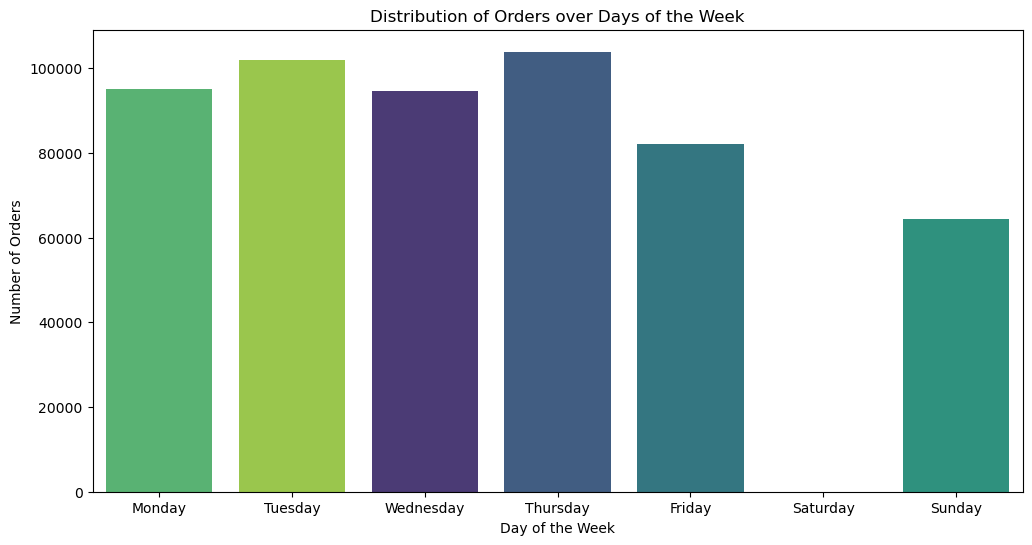

In [153]:
plt.figure(figsize=(12, 6))
sns.countplot(x='DayOfWeek', data=data, hue='DayOfWeek', legend=False, palette='viridis', order=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])
plt.title('Distribution of Orders over Days of the Week')
plt.xlabel('Day of the Week')
plt.ylabel('Number of Orders')
plt.show()


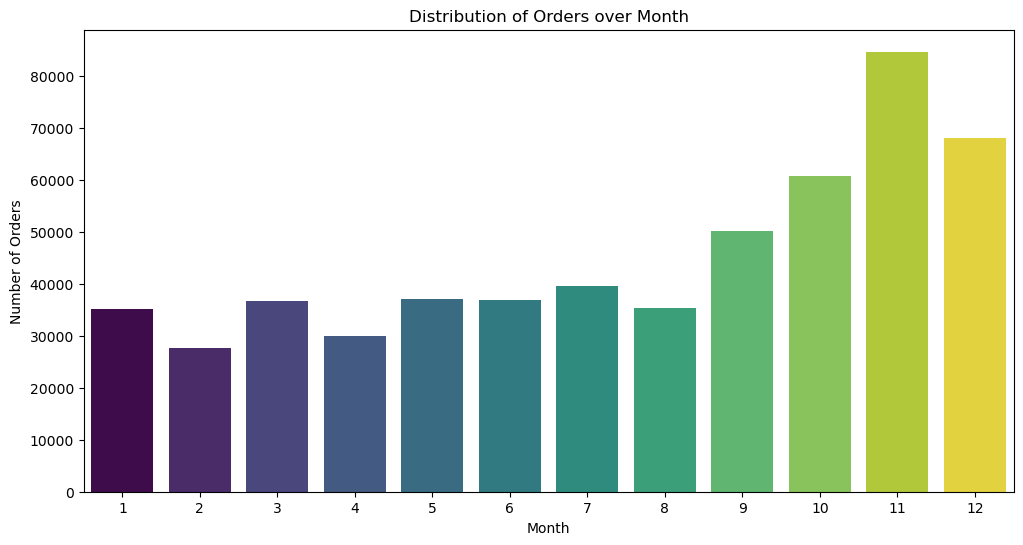

In [284]:
plt.figure(figsize=(12, 6))
sns.countplot(x='Month', data=data, hue='Month', legend=False,  palette='viridis')
plt.title('Distribution of Orders over Month')
plt.xlabel('Month')
plt.ylabel('Number of Orders')
plt.show()

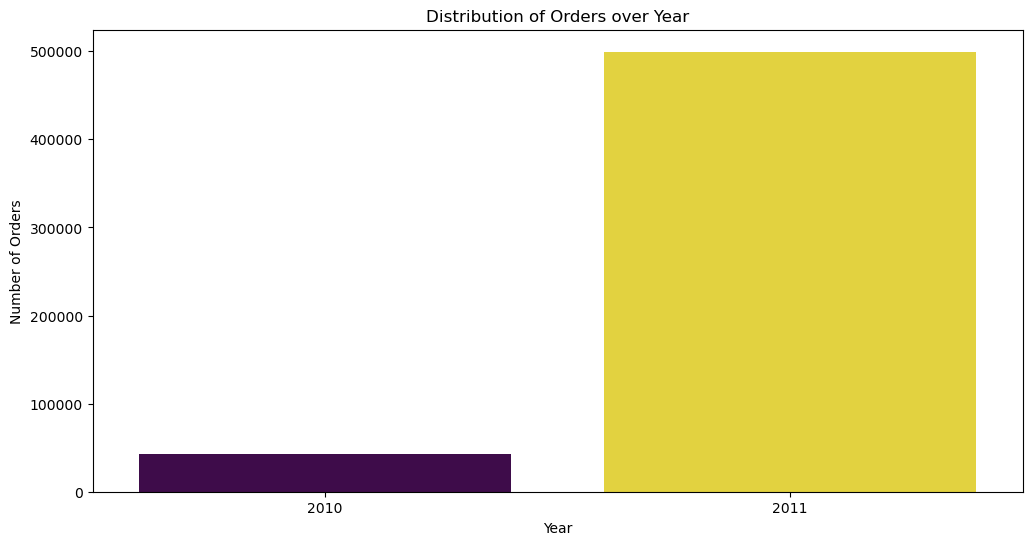

In [286]:
plt.figure(figsize=(12, 6))
sns.countplot(x='Year', data=data, hue='Year', legend=False, palette='viridis')
plt.title('Distribution of Orders over Year')
plt.xlabel('Year')
plt.ylabel('Number of Orders')
plt.show()

In [260]:
#5. Geographical Analysis

#(a)

import numpy as np
import pandas as pd

data['TotalAmount'] = data['Quantity'] * data['UnitPrice']
print(data.columns)

grouped_data = data.groupby('Country')
country_stats = grouped_data.agg({
    'CustomerID': 'nunique',
    'TotalAmount': 'mean'
}).rename(columns={'CustomerID': 'Number of Customers', 'TotalAmount': 'Average Order Value'})

correlation = np.corrcoef(country_stats['Number of Customers'], country_stats['Average Order Value'])[0, 1]
print("Correlation Between Number of Customers and Average Order Value:", correlation)

top_countries_by_orders = data['Country'].value_counts().head(5)

print("Top 5 Countries with the Highest Number of Orders:")
print(top_countries_by_orders)



Index(['InvoiceNo', 'StockCode', 'Description', 'Quantity', 'InvoiceDate',
       'UnitPrice', 'CustomerID', 'Country', 'TotalAmount'],
      dtype='object')
Correlation Between Number of Customers and Average Order Value: -0.11611647206793932
Top 5 Countries with the Highest Number of Orders:
Country
United Kingdom    495478
Germany             9495
France              8557
EIRE                8196
Spain               2533
Name: count, dtype: int64


In [207]:
(b)

import numpy as np

grouped_data = data.groupby('Country')
country_stats = grouped_data.agg({
    'CustomerID': 'nunique',
    'TotalAmount': 'mean'
}).rename(columns={'CustomerID': 'Number of Customers', 'TotalAmount': 'Average Order Value'})


average_order_value_by_country = country_stats['Average Order Value']

# Print average order value by country
print("Average Order Value by Country:")
print(average_order_value_by_country)

correlation = np.corrcoef(country_stats['Number of Customers'], country_stats['Average Order Value'])[0, 1]
print("Correlation Between Number of Customers and Average Order Value:", correlation)


Average Order Value by Country:
Country
Australia               108.877895
Austria                  25.322494
Bahrain                  28.863158
Belgium                  19.773301
Brazil                   35.737500
Canada                   24.280662
Channel Islands          26.499063
Cyprus                   20.813971
Czech Republic           23.590667
Denmark                  48.247147
EIRE                     32.122599
European Community       21.176230
Finland                  32.124806
France                   23.069288
Germany                  23.348943
Greece                   32.263836
Hong Kong                35.128611
Iceland                  23.681319
Israel                   26.625657
Italy                    21.034259
Japan                    98.716816
Lebanon                  37.641778
Lithuania                47.458857
Malta                    19.728110
Netherlands             120.059696
Norway                   32.378877
Poland                   21.152903
Portugal       

In [215]:
#6. Payment Analysis

(a) No data about payment methods

(b) the information needed to the payments analysis is not available


In [256]:
#7. Customer Behavior

#(a)

data['InvoiceDate'] = pd.to_datetime(data['InvoiceDate'])
customer_active_duration = data.groupby('CustomerID')['InvoiceDate'].agg(['min', 'max'])
customer_active_duration['ActiveDuration'] = customer_active_duration['max'] - customer_active_duration['min']
average_active_duration = customer_active_duration['ActiveDuration'].mean()
print("Average Customer Active Duration:", average_active_duration)

Average Customer Active Duration: 133 days 18:44:15.504230506


In [254]:
#(b)

from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

data['InvoiceDate'] = pd.to_datetime(data['InvoiceDate'])

recency = data.groupby('CustomerID')['InvoiceDate'].max()
frequency = data.groupby('CustomerID')['InvoiceNo'].nunique()
monetary = data.groupby('CustomerID')['TotalAmount'].sum()

rfm_data = pd.DataFrame({'Recency': recency, 'Frequency':frequency, 'Monetary':monetary})

rfm_data = rfm_data.reset_index()

customer_ids = rfm_data['CustomerID']

rfm_for_clustering = rfm_data[['Recency', 'Frequency', 'Monetary']]

scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(rfm_for_clustering.iloc[:, 1:])

num_clusters = 4
kmeans = KMeans(n_clusters=num_clusters, init='k-means++', random_state=42)
rfm_data['Cluster'] = kmeans.fit_predict(rfm_scaled)

cluster_profiles = rfm_data.groupby('Cluster').agg({
    'Recency': 'mean',
    'Frequency': 'mean',
    'Monetary' : 'mean',
    'CustomerID': 'count'
}).rename(columns={'CustomerID': 'Number of Customers'})

print("Cluster Profiles:")
print(cluster_profiles)






Cluster Profiles:
                              Recency    Frequency      Monetary  \
Cluster                                                            
0       2011-09-08 00:43:12.443930880     4.458728  1.342493e+03   
1       2011-12-09 10:26:00.000000000  3710.000000  1.447682e+06   
2       2011-12-04 10:16:33.658536448    57.853659  3.416323e+04   
3       2011-12-02 09:06:50.000000000    89.000000  1.821820e+05   

         Number of Customers  
Cluster                       
0                       4325  
1                          1  
2                         41  
3                          6  


In [ ]:
#8. Returns and Refunds

(a) No data about returns or refunds

(b) N/A
    

In [246]:
#9. Profitability Analysis

#(a)

data['InvoiceDate'] = pd.to_datetime(data['InvoiceDate'])
data['TotalAmount'] = data['Quantity'] * data['UnitPrice']
total_profit = data['TotalAmount'].sum()
print("Total Profit:", total_profit)

Total Profit: 9747747.933999998


In [252]:
#(b)

data['InvoiceDate'] = pd.to_datetime(data['InvoiceDate'])

data['TotalAmount'] = data['Quantity'] * data['UnitPrice']
product_profit = data.groupby('Description')['TotalAmount'].sum()
product_revenue = data.groupby('Description')['TotalAmount'].sum()

profit_margin = (product_profit / product_revenue) * 100

top_products = profit_margin.nlargest(5)
print("Top 5 Product with Highest Profit Margins:")
print(top_products)

Top 5 Product with Highest Profit Margins:
Description
4 PURPLE FLOCK DINNER CANDLES    100.0
50'S CHRISTMAS GIFT BAG LARGE    100.0
DOLLY GIRL BEAKER                100.0
I LOVE LONDON MINI BACKPACK      100.0
I LOVE LONDON MINI RUCKSACK      100.0
Name: TotalAmount, dtype: float64


In [ ]:
#10. Customer Satisfaction

(a) No,there is no data available on customer feedback or ratings for products or services

(b) N/A